In [51]:
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import numpy as np
import math
from abc import ABC, abstractmethod
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.base import BaseEstimator, RegressorMixin

In [70]:
csv_files = []
DD = [] 
for i in range(5):
    csv_files.append(pd.read_csv('data/s' + str(i) + '.csv'))
    
#Normalize so that range = [0,1]
for i in range(len(csv_files)):
    D = {}
    d = csv_files[i]
#     d.iloc[:, 0] = (d.iloc[:, 0] - d.iloc[:, 0].min()) / (d.iloc[:, 0].max() - d.iloc[:, 0].min())
#     d.iloc[:, 1] = (d.iloc[:, 1] - d.iloc[:, 1].min()) / (d.iloc[:, 1].max() - d.iloc[:, 1].min())
    D['x'] = ((d.iloc[:, 0] - d.iloc[:, 0].min()) / (d.iloc[:, 0].max() - d.iloc[:, 0].min())).to_numpy()
    D['y'] = ((d.iloc[:, 1] - d.iloc[:, 1].min()) / (d.iloc[:, 1].max() - d.iloc[:, 1].min())).to_numpy()
    D['name'] = i
    DD.append(D)

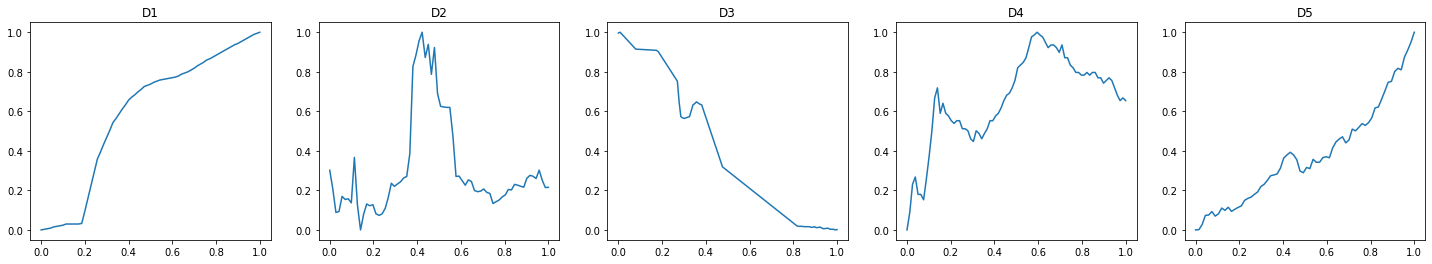

In [72]:
f = plt.figure()
f.set_figwidth(25)

for i in range(len(DD)):
    d = DD[i]
    dx = d['x']
    dy = d['y']
    plt.subplot(1, len(DD), (i+1))
    plt.title("D%s" % (i+1))
    plt.plot(dx,dy)

In [108]:
class IHumanProxy(ABC):
    
    @abstractmethod
    def fit(self, x, y):
        pass

    @abstractmethod
    def predict(self, x):
        pass

class Pipeline:
    """
    H: human proxy. Has fit(x, y), predict(x)
    T: teacher.
    evaluator: evaluates sample w.r.t original data.
    """
    def __init__(self, human_proxy, teacher, evaluator):
#         if not isinstance(human_proxy, IHumanProxy): raise Exception('Bad interface')
        self.H = human_proxy
        self.T = teacher
        self.E = evaluator

    def generate_sample(self, D):
        return self.T(D, self.E)

    def generate_plots(self, DD):
        f = plt.figure()
        f.set_figwidth(25)

        for i in range(len(DD)):
            D = DD[i]
            x = D['x'].reshape(-1, 1)
            y = D['y']

            sample, _ = self.generate_sample(D)

            model_sample = self.H(sample[0], sample[1])
            y_learned_from_sample = model_sample.predict(x)

            model_raw = self.H(x, y)
            y_learned_from_raw = model_raw.predict(x)
            
            distance = self.E(D, model_sample)

            plt.subplot(1, len(DD), (i+1)) 
            plt.title("D%s" % (i+1))
            plt.xlabel("distance = %.5f" % distance)
            plt.plot(x,y)
            plt.plot(x,y_learned_from_sample)
            plt.plot(x,y_learned_from_raw)
            plt.plot(sample[0], sample[1], 'ro')

In [111]:
class H_OLS(IHumanProxy):
    def __init__(self, x, y):
        self.model = LinearRegression()
        self.fit(x, y)
        
    def fit(self, x, y):
        self.model.fit(x, y)

    def predict(self, x):
        return self.model.predict(x)

def E_MSE(D, model):
    x = D['x'].reshape(-1, 1)
    y = D['y']
    y_predicted = model.predict(x)
    return mean_squared_error(y, y_predicted)

"""
Assumes: H is a oridnary least squares learner
Outputs: sample of size 2
Note: This teacher does not use actual H and E in the pipeline (White-Box)
"""
def T_OLS2(D, evaluator):
    x = D['x'].reshape(-1, 1)
    y = D['y']
    minDist = math.inf
    minS = [[],[]]
    h_tilde = LinearRegression()
    for i in range(len(x)):
        for j in range(i+1, len(x)):
            if i==j: continue
            x_sample = np.array([x[i], x[j]]).reshape(-1, 1)
            y_sample = np.array([y[i], y[j]])
            model = h_tilde.fit(x_sample, y_sample)
            y_predicted = h_tilde.predict(x)
            distance = mean_squared_error(y, y_predicted)
            if (distance < minDist):
                minDist = distance
                minS[0] = x_sample
                minS[1] = y_sample
    return minS, minDist

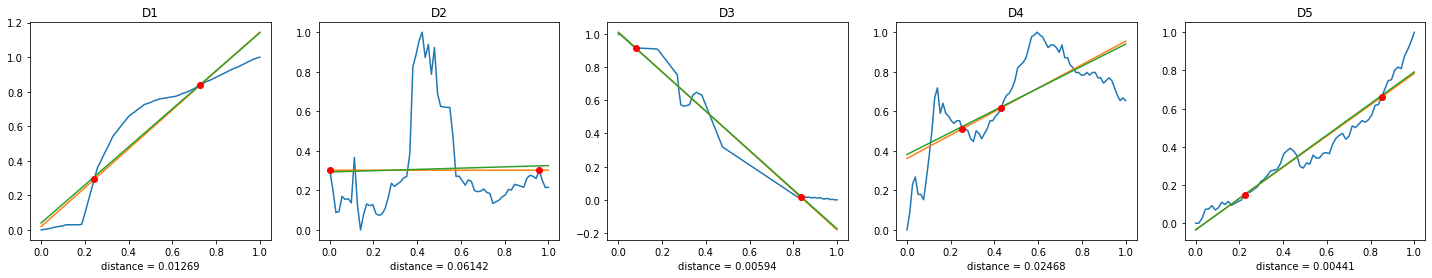

In [80]:
pipeline = Pipeline(human_proxy=H_OLS, teacher=T_OLS2, evaluator=E_MSE)
pipeline.generate_plots(DD)

In [81]:
class H_quad(IHumanProxy):
    def __init__(self, x, y):
        self.poly = PolynomialFeatures(degree=2, include_bias=True)
        self.model = LinearRegression()
        self.fit(self.poly.fit_transform(x), y)
        
    def fit(self, x, y):
        self.model.fit(x, y)

    def predict(self, x):
        return self.model.predict(self.poly.fit_transform(x))

def T_quad3(D, evaluator):
    x = D['x'].reshape(-1, 1)
    y = D['y']
    minDist = math.inf
    minS = [[],[]]
    poly = PolynomialFeatures(degree=2, include_bias=True)
    h_tilde = LinearRegression()
    for i in range(len(x)):
        for j in range(i+1, len(x)):
            for k in range(j+1, len(x)):
                x_sample = np.array([x[i], x[j], x[k]]).reshape(-1, 1)
                y_sample = np.array([y[i], y[j], y[k]])
                h_tilde.fit(poly.fit_transform(x_sample), y_sample)
                y_predicted = h_tilde.predict(poly.fit_transform(x))
                distance = mean_squared_error(y, y_predicted)
                if (distance < minDist):
                    minDist = distance
                    minS[0] = x_sample
                    minS[1] = y_sample
    return minS, minDist

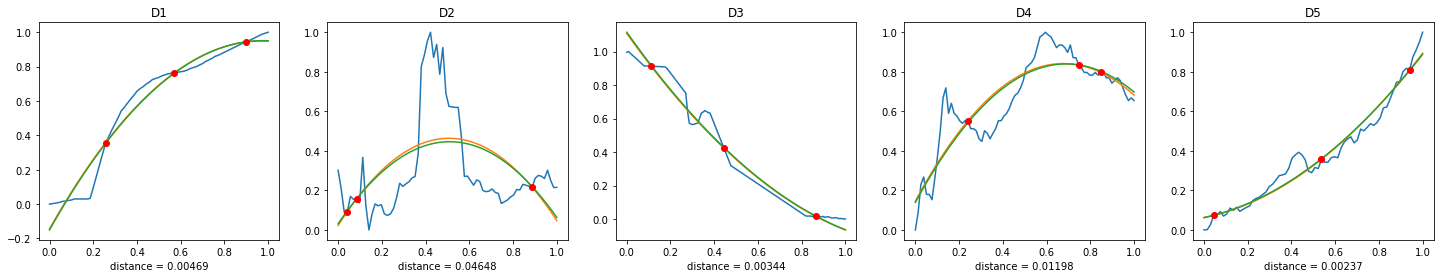

In [66]:
pipeline = Pipeline(human_proxy=H_quad, teacher=T_quad3, evaluator=E_MSE)
pipeline.generate_plots(DD)

In [97]:
#Piecewise Linear "connect the dots" learner
class H_PL(IHumanProxy):
    def __init__(self, x, y):
        self.fit(x, y)
        
    def fit(self, X, y):
        self.X = X
        self.y = y
    
    def predict(self, dX):
        dX = dX
        dy = np.zeros(len(dX))
        for i in range(len(dX)):
            dx = dX[i]
            x1 = 0
            x2 = 0
            k = len(self.X)
            for j in range(len(self.X)):
                if dx < self.X[j]:
                    k = j
                    break
            if k == 0:
                x1 = 0
                x2 = 1
            elif k == len(self.X):
                x1 = len(self.X) - 2
                x2 = len(self.X) - 1
            else:
                x1 = k - 1
                x2 = k
                
            dy[i] = self.y[x1] + (self.y[x2] - self.y[x1]) / (self.X[x2] - self.X[x1]) * (dx - self.X[x1])       
        return dy

def T_PL(D, n, evaluator):
    x = D['x'].reshape(-1, 1)
    y = D['y']
    did = D['name']
    if n==2:
        return T(x, y)
    minDist = math.inf
    minx0 = -1
    minx1 = -1
#     recnp = np.load("storage/recnp%s.npy" % (did)) #load from disk
#     recdist = np.load("storage/recdist%s.npy" % (did)) #load from disk
    recnp = np.ones([len(x), len(x)]) * -1
    recdist = np.ones([len(x), len(x)]) * -1
#     if recnp[prevx][n] != -1:
#         return recnp[prevx][n], recdist[prevx][n]
    
    for i in range(len(x)):
        for j in range(i + 1, len(x)):
            xcut = x[0:(j+1)]
            ycut = y[0:(j+1)]
            x_sample = np.array([x[i], x[j]])
            y_sample = np.array([y[i], y[j]])
            model = LinearRegression().fit(x_sample, y_sample)
            ycut_predicted = model.predict(xcut)
            distance = mean_squared_error(ycut, ycut_predicted)
            fx, fdist = T_PLRecursion(x, y, j, n-2, recnp, recdist)
            distance += fdist
            if distance < minDist:
                minDist = distance
                minx0 = i
                minx1 = j
    
    minSx = [x[minx0], x[minx1]]
    minSy = [y[minx0], y[minx1]]
    k = minx1
    for i in range(n-2):
        k = int(recnp[k][n-2-i])
        minSx.append(x[k])
        minSy.append(y[k])
    
    np.save("storage/recnp%s.npy" % (did),recnp) # save to disk
    np.save("storage/recdist%s.npy" % (did), recdist) # save to disk
    return [minSx, minSy], minDist

# returns array of size n, containing indexes of x that results in min distance 
def T_PLRecursion(x, y, prevx, n, recnp, recdist):
    if n == 0: return -1, 0
    if recnp[prevx][n] != -1:
        return recnp[prevx][n], recdist[prevx][n]
    minDist = math.inf
    minSx = 0
    xcut, ycut = [], []
    for i in range(prevx + 1, len(x)):
        if n == 1:
            xcut = x[prevx+1:len(x)]
            ycut = y[prevx+1:len(x)]
        else:
            xcut = x[prevx+1:(i+1)]
            ycut = y[prevx+1:(i+1)]
        x_sample = [x[prevx], x[i]]
        y_sample = [y[prevx], y[i]]
        model = LinearRegression().fit(x_sample, y_sample)
        ycut_predicted = model.predict(xcut)
        distance = mean_squared_error(ycut, ycut_predicted)
        fx, fdist = T_PLRecursion(x, y, i, n-1, recnp, recdist)
        distance += fdist
        if distance < minDist:
            minDist = distance
            minSx = i
    
    recdist[prevx][n] = minDist
    recnp[prevx][n] = minSx  
    return minSx, minDist

def T_PL7(D, evaluator):
    return T_PL(D, 7, evaluator)

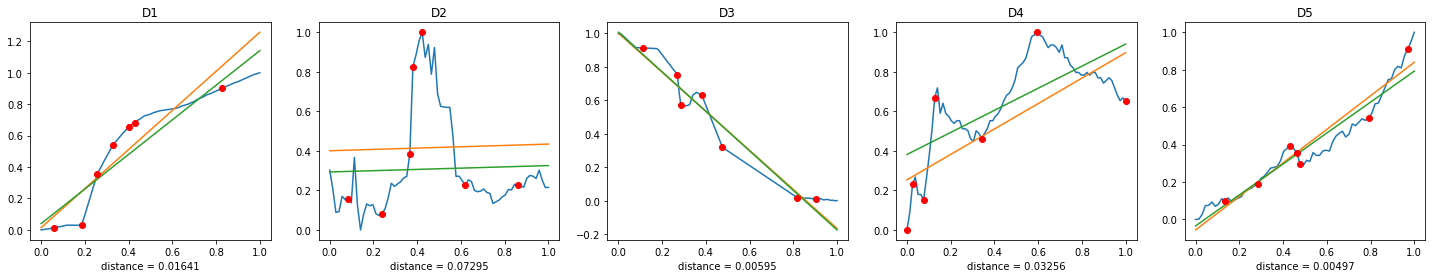

In [112]:
pipeline = Pipeline(human_proxy=H_OLS, teacher=T_PL7, evaluator=E_MSE)
pipeline.generate_plots(DD)

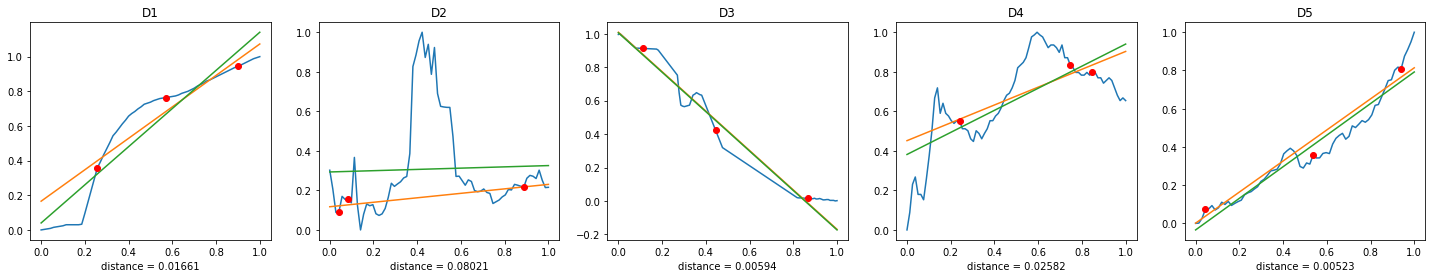

In [113]:
pipeline = Pipeline(human_proxy=H_OLS, teacher=T_quad3, evaluator=E_MSE)
pipeline.generate_plots(DD)

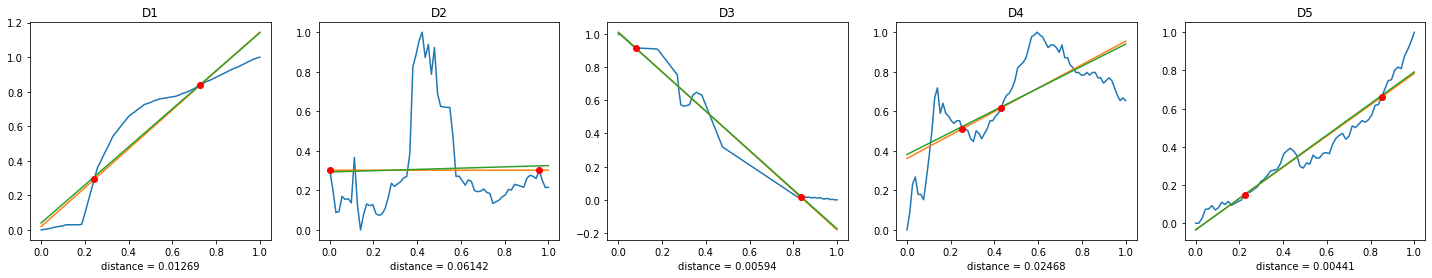

In [114]:
pipeline = Pipeline(human_proxy=H_OLS, teacher=T_OLS2, evaluator=E_MSE)
pipeline.generate_plots(DD)

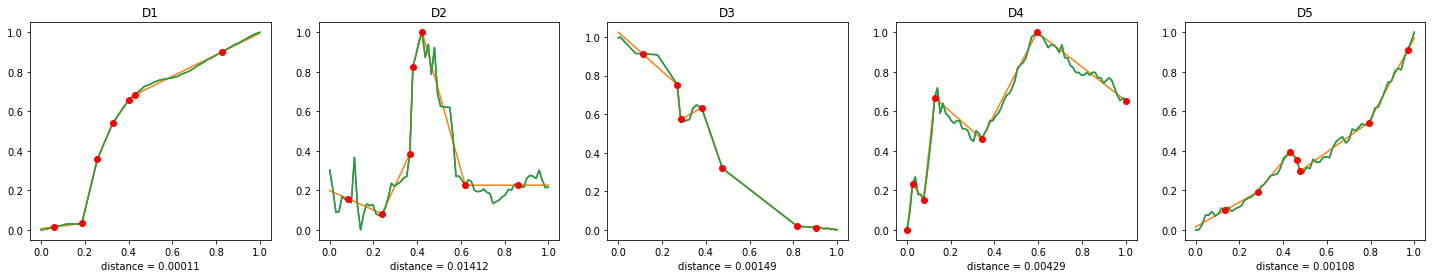

In [103]:
pipeline = Pipeline(human_proxy=H_PL, teacher=T_PL7, evaluator=E_MSE)
pipeline.generate_plots(DD)

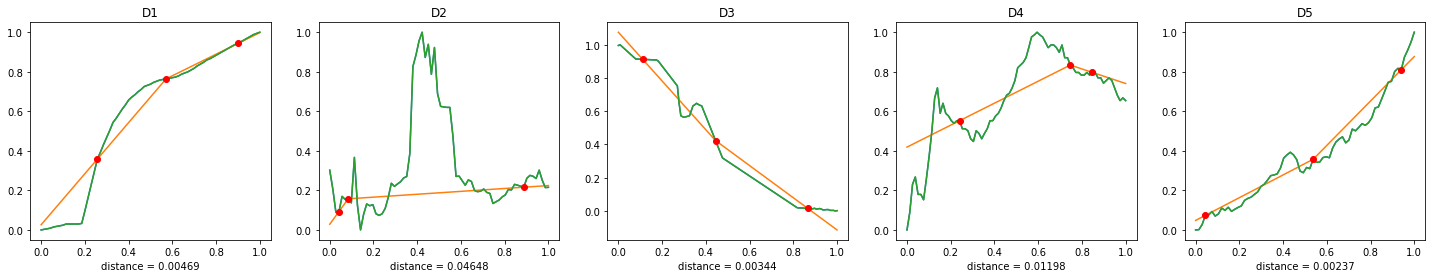

In [104]:
pipeline = Pipeline(human_proxy=H_PL, teacher=T_quad3, evaluator=E_MSE)
pipeline.generate_plots(DD)

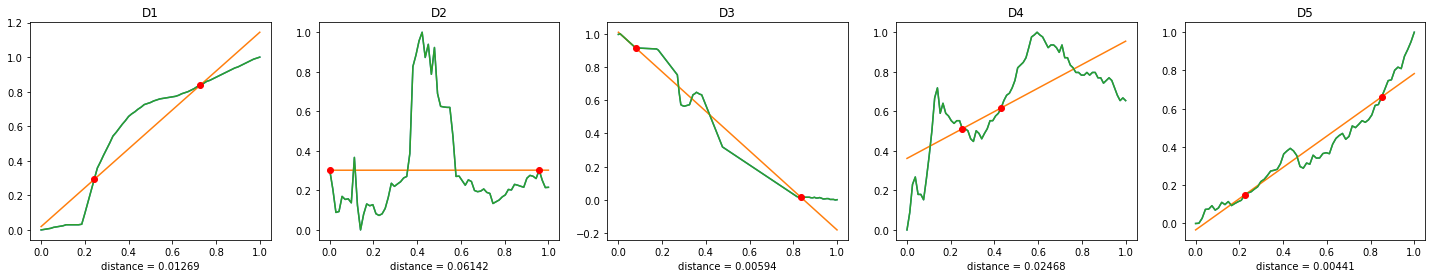

In [105]:
pipeline = Pipeline(human_proxy=H_PL, teacher=T_OLS2, evaluator=E_MSE)
pipeline.generate_plots(DD)

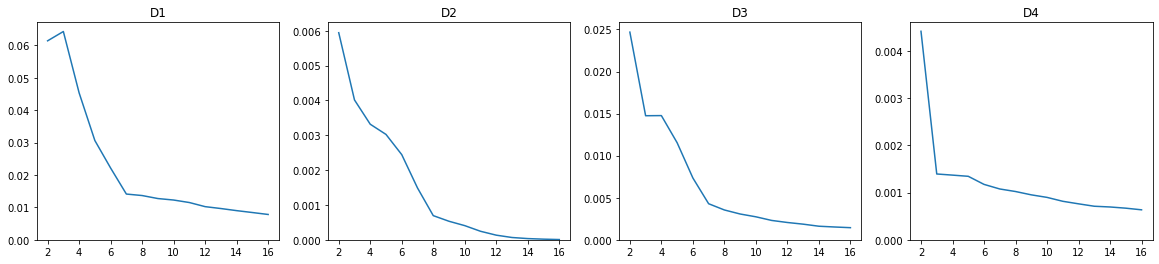

In [157]:
f = plt.figure()
f.set_figwidth(20)

start = 2
end = 16
for i in range(len(DD)):
    d = DD[i]
    dx = d.iloc[:, 0].to_numpy()
    dy = d.iloc[:, 1].to_numpy()
    errx = np.arange(start, end+1)
    erry = np.zeros(len(errx))
    for n in errx:
        s, distance = T_PL(dx.reshape(-1, 1), dy, n, i)
        erry[n-start] = distance + 0.001

#     modelraw = H_PL(dx, dy)
#     rawdist = dist_PL(dx, dy, modelraw)
#     rawdistx = np.array([start, end])
#     rawdisty = np.array([rawdist, rawdist]
#     for n in errx:
    plt.subplot(1, len(DD), (i+1)) 
    plt.title("D%s" % (i+1))
    plt.plot(errx,erry)
    plt.gca().set_ylim(bottom=0)
    
    np.save("erry%s.npy" % (i), erry) # save to disk
#     plt.plot(rawdistx, rawdisty)

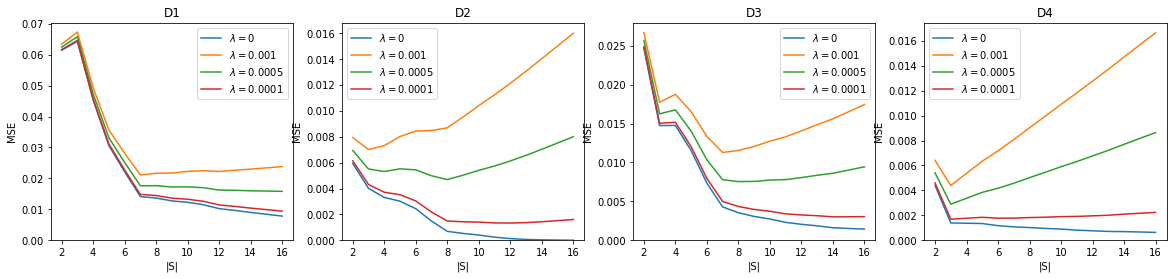

In [171]:
f = plt.figure()
f.set_figwidth(20)
rps = [0.001, 0.0005, 0.0001]
for i in range(len(DD)):
    errx = np.arange(start, end+1)
    erry = np.load("erry%s.npy" % (i))
    errys = []
    for rp in rps:
        err = erry.copy()
        for j in range(len(errx)):
            err[j] += rp * errx[j]
        errys.append(err)
   
    plt.subplot(1, len(DD), (i+1)) 
    plt.title("D%s" % (i+1))
    plt.xlabel("|S|")
    plt.ylabel("MSE")
    plt.plot(errx, erry, label=r'$\lambda = 0$')
    for j in range(len(rps)):
        plt.plot(errx,errys[j], label=r'$\lambda = %s$' % rps[j])
    plt.gca().set_ylim(bottom=0)
    plt.legend()

# 